# Mapping Race and Ethnicity in Durham, NC

In this exercise, we will return to our ACS data from Durham to do some mapping of race and ethnicity in our county.

### Exercise 1

Please load the ACS data into geopandas using the `gpd.read_file` function to read [this file](https://github.com/nickeubank/MIDS_Data/blob/master/nc_acs_blockgroups/nc_acs_blockgroups.geojson) once more, and again subset for Durham County.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("retina")
nick_theme = {**style.library["seaborn-v0_8-whitegrid"]}
nick_theme.update({"font.sans-serif": ["Fira Sans", "Arial", "sans-serif"]})
plt.rcParams.update(nick_theme)

pd.set_option("mode.copy_on_write", True)

<Axes: >

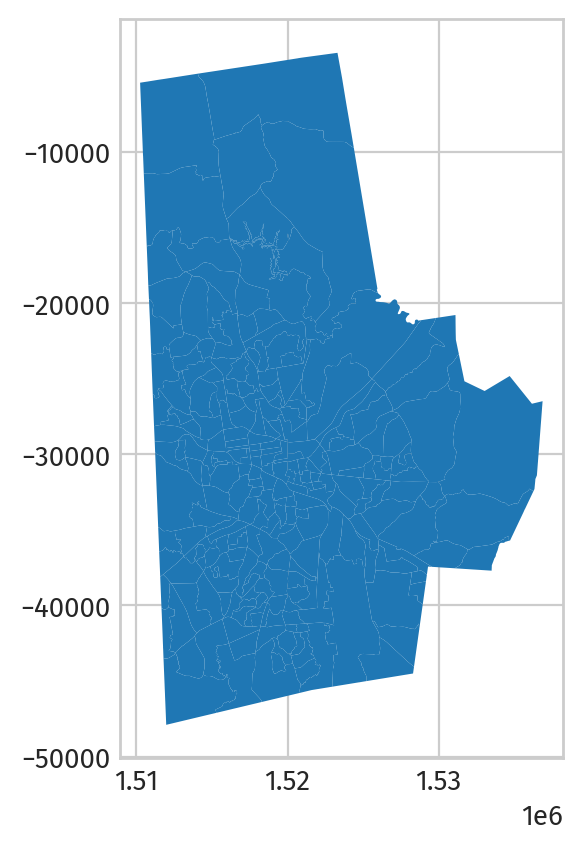

In [2]:
acs = gpd.read_file(
    "https://github.com/nickeubank/MIDS_Data/raw/refs/heads/master/nc_acs_blockgroups/nc_acs_blockgroups.geojson"
)
durham = acs[acs.COUNTY == "Durham County"]
durham.plot()

### Exercise 2

In our last exercise, you made a chloropleth map of per capita income. Please do so again.

In [3]:
durham["ASRTE001"] = durham["ASRTE001"].replace({-666666666: np.nan})
durham = durham.rename(columns={"ASRTE001": "per_capita_income"})

<Axes: >

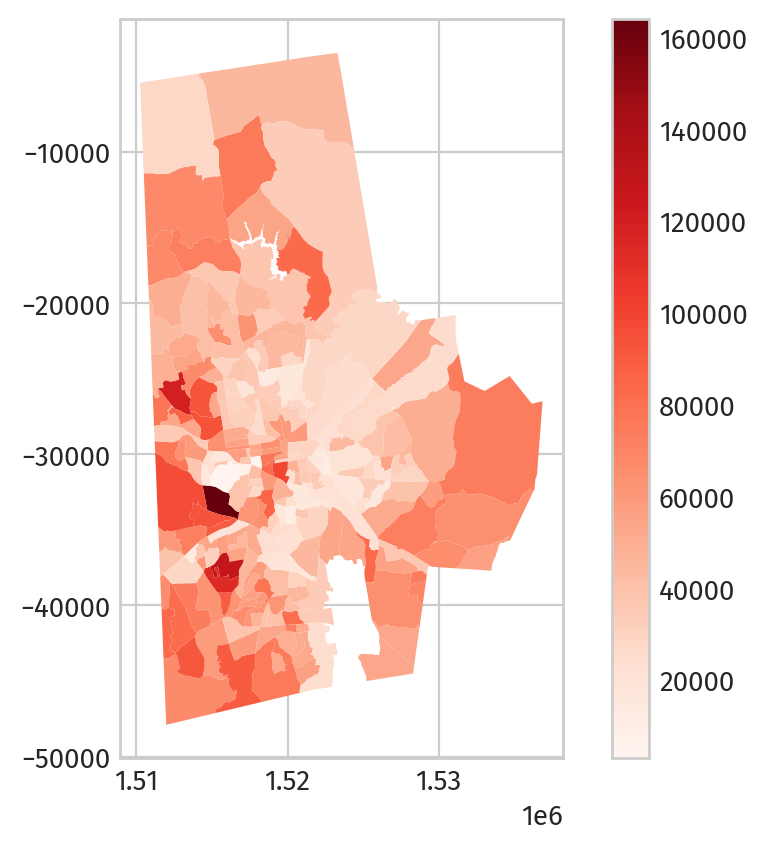

In [4]:
durham.plot("per_capita_income", cmap="Reds", legend=True)

### Exercise 3

It can be hard to "see" how these polygons correspond to places you know in the real world when you just see these shapes. To help, add a basemap using the [contextily](https://contextily.readthedocs.io/en/latest/) package.

Just plot your map explicitly onto a matplotlib axes `ax`, then run:

```python

import contextily as cx
cx.add_basemap(ax, crs=your_geodataframe_name.crs)
```

where you replace `your_geodataframe_name` with the name of your Durham geodataframe. I'm calling mine `durham`, so I'd put in `durham.crs`. 

We haven't discussed what the `crs=your_geodataframe_name.crs` code is doing, or even what a `crs` object is. If you know about projections, a crs is how projection data is represented in Python. If you don't, we'll get to it in a couple days. For now, though, just pass that keyword.

Note that to make your polygons more transparent so you can see through them to the underlying basemap a little, you will probably also want to pass `alpha=0.5` when you plot the polygons. `alpha` controls the opacity of a layer — 1 (default) is fully opaque, and 0 is fully transparent.

Can you now tell where the wealthiest area in Durham is located? You can crop the image using `ax.set_xlim()`
and `ax.set_ylim()`.


/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_77081/343022170.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


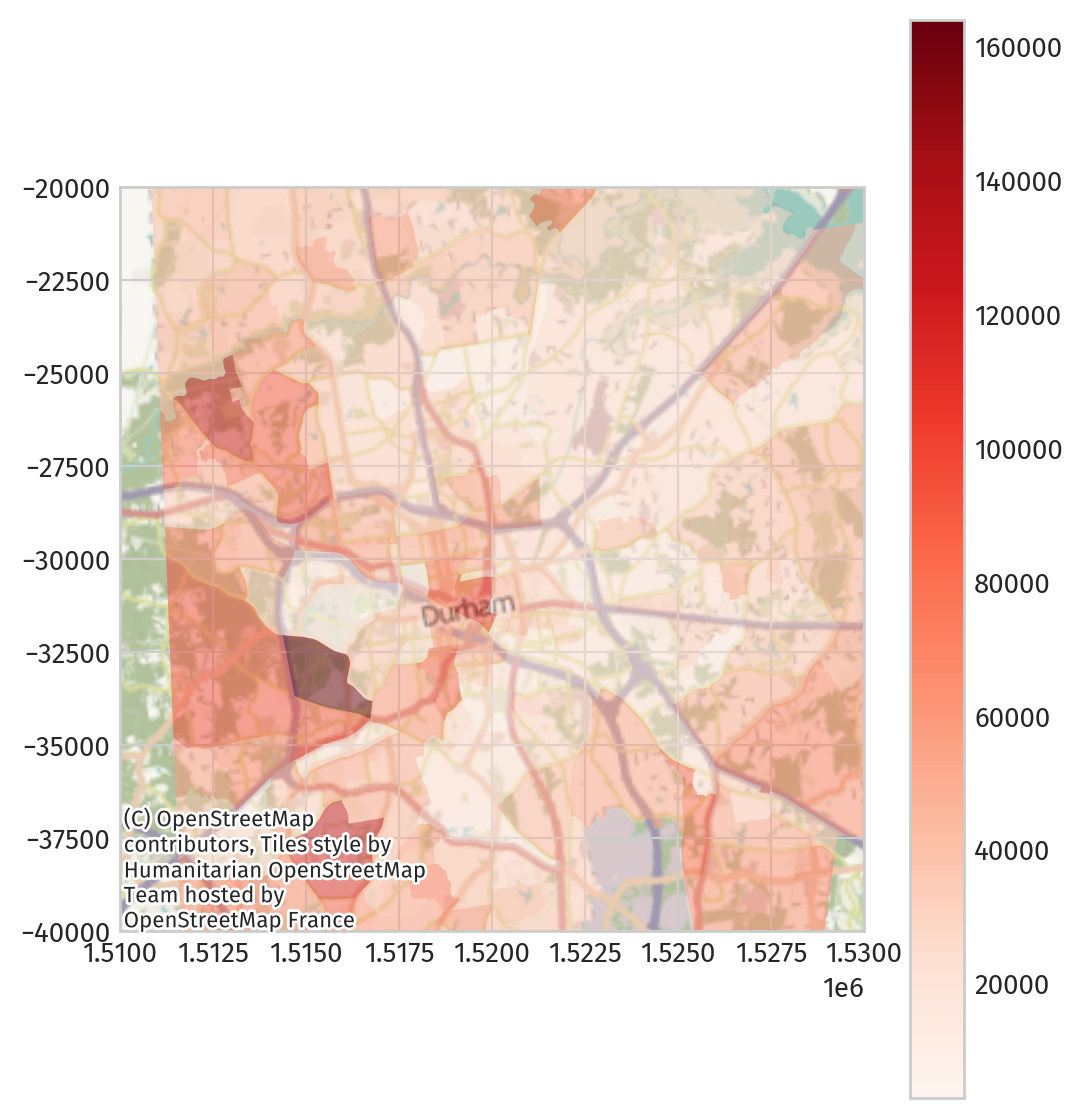

In [5]:
import contextily as cx

fig, ax = plt.subplots(figsize=(6, 7))
durham.plot("per_capita_income", ax=ax, cmap="Reds", legend=True, alpha=0.5)
cx.add_basemap(ax, crs=durham.crs)
ax.set_xlim(1_510_000, 1_530_000)
ax.set_ylim(-40_000, -20_000)
fig.show()

### Exercise 4

Now that we've gotten some practice doing mapping of income, let's do something a little more challenging — let's try to get a sense of the spatial distribution of people around Durham, and in particular how residents of different racial identities are distributed. 

For each block group, calculate the share of the block group that identifies as:

- non-Hispanic White,
- non-Hispanic Black, 
- Hispanic, and
- the share that does not identify in one of these categories.

Again, you will probably need to use the codebook. BE CAREFUL WITH VARIABLE CODINGS — there is some nuance to how they work, including:

- For the US Census, Hispanic/Latino is thought of as a different dimension of identity from race (White, Black, Asian, etc.). So for the US Census, a person who identifies as Black could be Black and Hispanic, or Black and non-Hispanic. 
- The US Census does allow people to identify as multi-racial. To keep things simple, this data only includes the simplified race codings in which multi-racial individuals are pooled into a "Two or more races" category. If you are interested in multi-racial identity, you can also get data in which the specific ways in which people identify are broken out in exceptional detail.  

In [6]:
durham = durham.rename(
    columns={
        "ASN1E001": "total_pop",
        "ASOAE012": "hispanic",
        "ASOAE003": "white",
        "ASOAE004": "black",
        "ASN1E001": "total_pop",
    }
)
assert (durham["total_pop"] == durham["ASOAE001"]).all()

In [7]:
durham["share_hispanic"] = durham["hispanic"] / durham["total_pop"]
durham["share_white"] = durham["white"] / durham["total_pop"]
durham["share_black"] = durham["black"] / durham["total_pop"]
durham["share_other"] = (
    1
    - (durham["share_hispanic"] + durham["share_white"] + durham["share_black"])
    / durham["total_pop"]
)

/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_77081/2337540119.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


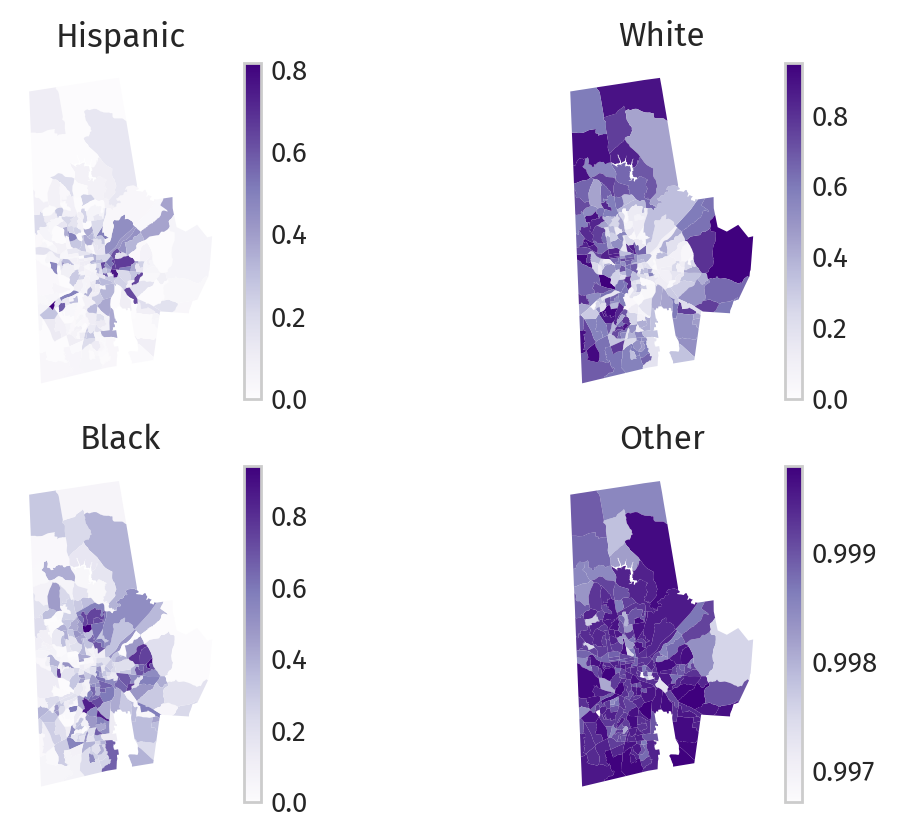

In [8]:
fig, axs = plt.subplots(2, 2)

for idx, i in enumerate(["hispanic", "white", "black", "other"]):
    this_ax = axs.flatten()[idx]
    durham.plot(f"share_{i}", cmap="Purples", ax=this_ax, legend=True)
    this_ax.set_title(i.capitalize())
    this_ax.set_axis_off()
fig.show()

### Exercise 5

This style of visualizing the distribution of a population is ok, but it's not the best. One problem is that the block groups with the most people tend to be the smallest, and the block groups with the fewest people tend to be the biggest. As a result, the visual field gives more weight to areas with fewer people and vice versa.

A better strategy is to make a dot-plot, in which we replace our polygons with random dots, where the number of random dots we make in each polygon is proportionate to the number of people in the polygon.

Use the `sample_points()` method to create one point in each polygon for every 100 people in each polygon. Then plot that dot-plot. You will probably need to reduce the size of your dots (`markersize` argument). 
**NOTE:** Calculating the right number of points in each block group requires a little nuance. It's easy to get *about* right — divide number of people by 100. But since the number of points has to be an integer, you have to add one point with a probability equal to the non-integer component that's left.

I used this little function which takes a vector of populations (`population`) and returns a number of points per row.

```python
import numpy.random as npr

def get_num_points(population, people_per_point):
        
    integer_component = (population / people_per_point).astype("int")
    just_decimal_component = (population / people_per_point) % 1

    # random draw from 0/1 with prob from decimal
    extra = npr.binomial(1, just_decimal_component)

    num_points = integer_component + extra
    return num_points

```

**Where do most people in Durham County live?** Does this give you a better sense of that than the polygon map?


<Axes: >

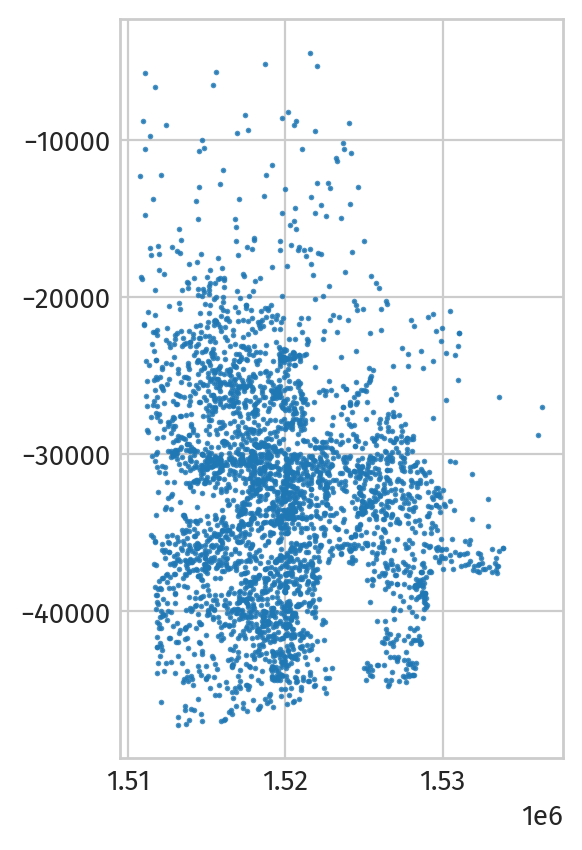

In [9]:
import numpy.random as npr


def get_num_points(population, people_per_point):

    integer_component = (population / people_per_point).astype("int")
    just_decimal_component = (population / people_per_point) % 1

    # random draw from 0/1 with prob from decimal
    extra = npr.binomial(1, just_decimal_component)

    num_points = integer_component + extra
    return num_points


p = get_num_points(durham["total_pop"], 100)
durham.geometry.sample_points(p).plot(markersize=1, alpha=0.8)

> Most people live is southern/central Durham!

### Exercise 6

OK, great. Now let's combine the data on race with this type of point map. Let's just map the Hispanic, non-Hispanic White, and non-Hispanic Black populations.

Rather than just creating three different collections of points — one for each group — we are going to create create three sets of points then concatenate them into one GeoDataFrame that has all the points concatenated together and a `race` column that identifies the race of each set of points. Note this will be a little trickier than for `pandas`, but I think you can do it!

Create that GeoDataFrame and plot it where all points representing residents of a given race have the same color. Make one point per 30 people. 

You may need to play with the value of `alpha` when plotting — `alpha` controls the opacity of points, with values of 1 denoting fully opaque and 0 denoting fully transparent. When plots have overlapping points, some transparency helps readability.

(Remember LLMs are great for tweaking matplotlib plots — settings colors, etc.!) You may also want to crop the image down again to central durham for visibility.

Finally, also add a basemap so you can see where things are.

/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_77081/2124844352.py:14: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  all_points.plot(


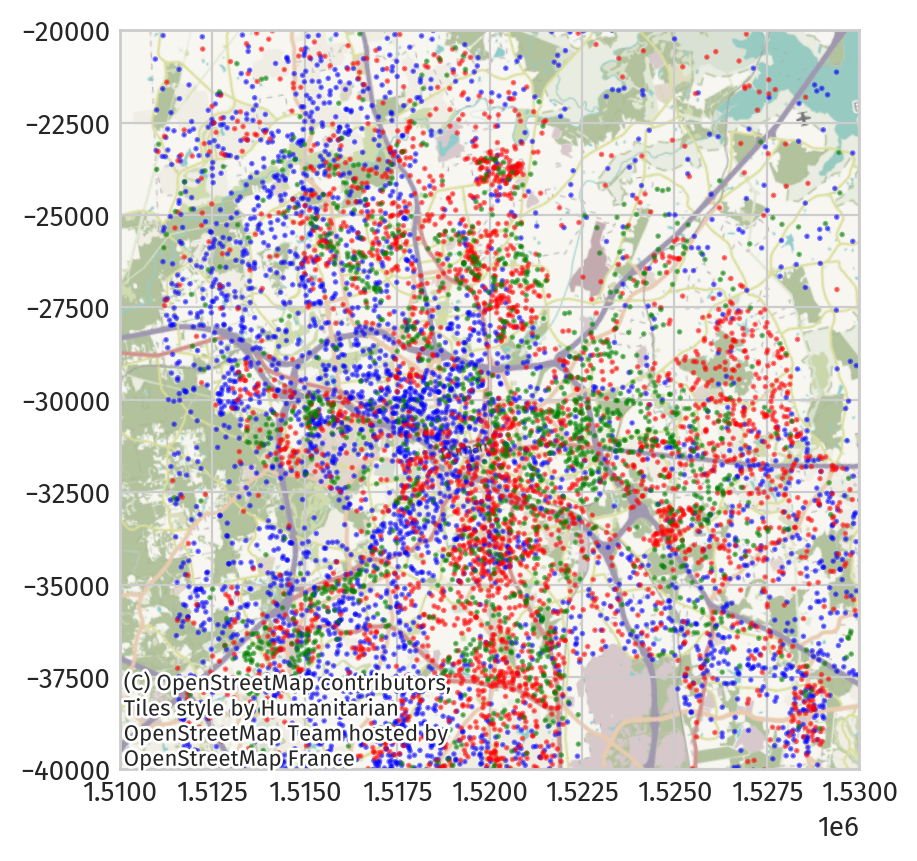

In [10]:
all_points = list()
for i in ["white", "black", "hispanic"]:
    p = get_num_points(durham[i], 30)
    points = gpd.GeoDataFrame(durham.geometry.sample_points(p))
    points["race"] = i
    all_points.append(points)

all_points = pd.concat(all_points)
all_points = all_points.set_geometry("sampled_points")
# Define a color mapping for your categories
color_map = {"white": "blue", "black": "red", "hispanic": "green"}

fig, ax = plt.subplots()
all_points.plot(
    "race",
    ax=ax,
    markersize=1,
    alpha=0.5,
    color=all_points["race"].map(color_map),
    legend=True,
)
ax.set_xlim(1_510_000, 1_530_000)
ax.set_ylim(-40_000, -20_000)

cx.add_basemap(ax=ax, crs=all_points.crs)

### Exercise 7

Finally, let's try putting these points on an interactive follium map. I say "try" because follium maps can be a little finicky when you open them in VS Code notebooks. As a reminder from the mapping reading, it seems like two things must be true for a follium map to work:

- You have to use an `epsg` projection crs. Again, we haven't talked about `crs` objects and projections yet, so it's sufficient to say "use the `.to_crs(epsg=3857)` method before running."
- It seems like sometimes if I try and modify the mapping code and re-run it, the map seems to not work until you fully restart your kernel and re-run the code.

So give it a shot. My geodataframe of points is called `all_points`, and the column that labels points as being associated with a specific race is called `"race"`, so for me the code I'll run is:

```python

all_points.to_crs(epsg=3857).explore("race")

```

In [11]:
all_points.to_crs(epsg=3857).explore(
    "race", cmap=["red", "green", "blue"], markersize=1
)

### Exercise 8

To make life easier for grading, we aren't going to have you submit this raw notebook. Instead, please submit a notebook that only contains a couple finished maps based on the code you developed here. Your maps should include titles, legends, etc. 

Your final notebook should have:

1. Chloropleth map of incomes with an underlying basemap.
2. Four chloropleth maps of the share of each block group that identifies with one of the listed racial groups.
3. A racial point density map for Durham with underlying basemap.
4. An attempt at a follium interactive map.
